In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
#"from sklearn.model_selection import StratifiedKFold" instead of  "from sklearn.cross_validation import StratifiedKFold"
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
d=pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS 1: Quora Question Pair Similarity/final_features.csv', sep='\t')
print(list(d.columns))

['Unnamed: 0', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_

In [0]:
d.shape

(100000, 629)

# 4.1 Reading data from file and storing into sql table

In [0]:
disk_engine=create_engine('sqlite:///train.db')
start=dt.datetime.now()
index_start=1
j=0
chunksize=50000
for df in pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS 1: Quora Question Pair Similarity/final_features.csv', names=['Unnamed: 0', 'id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', '32_x', '33_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', '42_x', '43_x', '44_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '59_x', '60_x', '61_x', '62_x', '63_x', '64_x', '65_x', '66_x', '67_x', '68_x', '69_x', '70_x', '71_x', '72_x', '73_x', '74_x', '75_x', '76_x', '77_x', '78_x', '79_x', '80_x', '81_x', '82_x', '83_x', '84_x', '85_x', '86_x', '87_x', '88_x', '89_x', '90_x', '91_x', '92_x', '93_x', '94_x', '95_x', '96_x', '97_x', '98_x', '99_x', '100_x', '101_x', '102_x', '103_x', '104_x', '105_x', '106_x', '107_x', '108_x', '109_x', '110_x', '111_x', '112_x', '113_x', '114_x', '115_x', '116_x', '117_x', '118_x', '119_x', '120_x', '121_x', '122_x', '123_x', '124_x', '125_x', '126_x', '127_x', '128_x', '129_x', '130_x', '131_x', '132_x', '133_x', '134_x', '135_x', '136_x', '137_x', '138_x', '139_x', '140_x', '141_x', '142_x', '143_x', '144_x', '145_x', '146_x', '147_x', '148_x', '149_x', '150_x', '151_x', '152_x', '153_x', '154_x', '155_x', '156_x', '157_x', '158_x', '159_x', '160_x', '161_x', '162_x', '163_x', '164_x', '165_x', '166_x', '167_x', '168_x', '169_x', '170_x', '171_x', '172_x', '173_x', '174_x', '175_x', '176_x', '177_x', '178_x', '179_x', '180_x', '181_x', '182_x', '183_x', '184_x', '185_x', '186_x', '187_x', '188_x', '189_x', '190_x', '191_x', '192_x', '193_x', '194_x', '195_x', '196_x', '197_x', '198_x', '199_x', '200_x', '201_x', '202_x', '203_x', '204_x', '205_x', '206_x', '207_x', '208_x', '209_x', '210_x', '211_x', '212_x', '213_x', '214_x', '215_x', '216_x', '217_x', '218_x', '219_x', '220_x', '221_x', '222_x', '223_x', '224_x', '225_x', '226_x', '227_x', '228_x', '229_x', '230_x', '231_x', '232_x', '233_x', '234_x', '235_x', '236_x', '237_x', '238_x', '239_x', '240_x', '241_x', '242_x', '243_x', '244_x', '245_x', '246_x', '247_x', '248_x', '249_x', '250_x', '251_x', '252_x', '253_x', '254_x', '255_x', '256_x', '257_x', '258_x', '259_x', '260_x', '261_x', '262_x', '263_x', '264_x', '265_x', '266_x', '267_x', '268_x', '269_x', '270_x', '271_x', '272_x', '273_x', '274_x', '275_x', '276_x', '277_x', '278_x', '279_x', '280_x', '281_x', '282_x', '283_x', '284_x', '285_x', '286_x', '287_x', '288_x', '289_x', '290_x', '291_x', '292_x', '293_x', '294_x', '295_x', '296_x', '297_x', '298_x', '299_x', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y', '33_y', '34_y', '35_y', '36_y', '37_y', '38_y', '39_y', '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', '58_y', '59_y', '60_y', '61_y', '62_y', '63_y', '64_y', '65_y', '66_y', '67_y', '68_y', '69_y', '70_y', '71_y', '72_y', '73_y', '74_y', '75_y', '76_y', '77_y', '78_y', '79_y', '80_y', '81_y', '82_y', '83_y', '84_y', '85_y', '86_y', '87_y', '88_y', '89_y', '90_y', '91_y', '92_y', '93_y', '94_y', '95_y', '96_y', '97_y', '98_y', '99_y', '100_y', '101_y', '102_y', '103_y', '104_y', '105_y', '106_y', '107_y', '108_y', '109_y', '110_y', '111_y', '112_y', '113_y', '114_y', '115_y', '116_y', '117_y', '118_y', '119_y', '120_y', '121_y', '122_y', '123_y', '124_y', '125_y', '126_y', '127_y', '128_y', '129_y', '130_y', '131_y', '132_y', '133_y', '134_y', '135_y', '136_y', '137_y', '138_y', '139_y', '140_y', '141_y', '142_y', '143_y', '144_y', '145_y', '146_y', '147_y', '148_y', '149_y', '150_y', '151_y', '152_y', '153_y', '154_y', '155_y', '156_y', '157_y', '158_y', '159_y', '160_y', '161_y', '162_y', '163_y', '164_y', '165_y', '166_y', '167_y', '168_y', '169_y', '170_y', '171_y', '172_y', '173_y', '174_y', '175_y', '176_y', '177_y', '178_y', '179_y', '180_y', '181_y', '182_y', '183_y', '184_y', '185_y', '186_y', '187_y', '188_y', '189_y', '190_y', '191_y', '192_y', '193_y', '194_y', '195_y', '196_y', '197_y', '198_y', '199_y', '200_y', '201_y', '202_y', '203_y', '204_y', '205_y', '206_y', '207_y', '208_y', '209_y', '210_y', '211_y', '212_y', '213_y', '214_y', '215_y', '216_y', '217_y', '218_y', '219_y', '220_y', '221_y', '222_y', '223_y', '224_y', '225_y', '226_y', '227_y', '228_y', '229_y', '230_y', '231_y', '232_y', '233_y', '234_y', '235_y', '236_y', '237_y', '238_y', '239_y', '240_y', '241_y', '242_y', '243_y', '244_y', '245_y', '246_y', '247_y', '248_y', '249_y', '250_y', '251_y', '252_y', '253_y', '254_y', '255_y', '256_y', '257_y', '258_y', '259_y', '260_y', '261_y', '262_y', '263_y', '264_y', '265_y', '266_y', '267_y', '268_y', '269_y', '270_y', '271_y', '272_y', '273_y', '274_y', '275_y', '276_y', '277_y', '278_y', '279_y', '280_y', '281_y', '282_y', '283_y', '284_y', '285_y', '286_y', '287_y', '288_y', '289_y', '290_y', '291_y', '292_y', '293_y', '294_y', '295_y', '296_y', '297_y', '298_y', '299_y'], chunksize=chunksize, iterator=True, encoding='utf-8', sep='\t'):
  df.index += index_start
  j +=1
  print('{} rows'.format(j*chunksize))
  df.to_sql('data', disk_engine, if_exists='append')
  index_start = df.index[-1] +1

50000 rows
100000 rows
150000 rows


In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [0]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [0]:
if os.path.isfile(read_db):
  conn_r = create_connection(read_db)

  if conn_r is not None:
    data = pd.read_sql_query("SELECT *FROM data ORDER BY RANDOM() LIMIT 10000", conn_r)
    conn_r.commit()
    conn_r.close()


In [0]:
data.head(5)

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,260_y,261_y,262_y,263_y,264_y,265_y,266_y,267_y,268_y,269_y,270_y,271_y,272_y,273_y,274_y,275_y,276_y,277_y,278_y,279_y,280_y,281_y,282_y,283_y,284_y,285_y,286_y,287_y,288_y,289_y,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,147048,97046.0,97046,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,10.0,9,9,24,27,0.0408163265306122,1,1,48,64,8,12,0.0,20.0,0.0,2,0,8.53128646779805,5.82718880474567,-20.238721258007,-2.8713231086731,-13.7682129815221,4.68287481367588,-8.06298795342445,8.24375388026237,-1.87336814403534,68.8341946601868,...,5.17806266248226,8.62425380945206,-4.39841835200787,32.8439855575561,-4.97240303456783,-20.6057109236717,-4.14850440621376,-7.10396323725581,20.7840289473534,-20.8155137300491,29.5128493309021,-1.34700049459934,-15.2434372901917,5.47722607851028,11.8299979772419,10.290137834847,3.50204195082188,1.91103257983923,14.8417667280883,13.6386568211019,22.8955321907997,-0.115002926439047,-9.71516624093056,22.1168529987335,10.8145848065615,-14.2921018525958,6.60313806682825,-2.88275171071291,3.91428903490305,22.1228040754795,-25.2819273471832,7.45600855350494,6.73661776259542,10.1175571382046,7.42985185980797,-26.2497853524983,-9.73837958276272,14.2841628119349,-0.918014019727707,22.7976446226239
1,26368,26366.0,26366,1,0.499991666805553,0.499991666805553,0.33332222259258,0.199996000079998,0.444439506227709,0.363633057881292,0.0,0.0,2.0,10.0,70,64,68,69,0.426229508196721,1,1,60,63,11,9,4.0,20.0,0.2,2,0,-12.2829747200012,2.87305331230164,-3.57319557666779,-1.66393235325813,8.14275443553925,3.71992722153664,11.0792710110545,-13.401635736227,9.44541800394654,88.832660920918,...,21.7253766953945,13.8053521811962,-8.28676727414131,3.81735703349114,1.52099362015724,-7.43041145801544,1.47521159052849,1.70127285644412,7.60888288915157,-23.3837346732616,11.6927000880241,4.19849532842636,1.97074148058891,-5.09648406878114,9.52375693246722,2.43656866811216,-10.8900954425335,-2.60204792767763,3.22060808539391,5.66899889335036,13.0300512909889,11.9160142838955,5.45079809427261,-2.00240651518106,3.88976333662868,-1.17256066389382,8.3153510838747,1.26550537347794,-5.35014524310827,-13.7722401022911,-8.88176047801971,-11.0890404284,6.99698252603412,6.85462209582329,10.3783376514912,-3.77885334938765,-4.38562020659447,-4.24006950855255,-7.33391830325127,7.74072626978159
2,112274,62272.0,62272,0,0.249993750156246,0.0555552469152949,0.374995312558593,0.333329629670781,0.333330555578704,0.137930558860142,0.0,0.0,17.0,20.5,68,44,36,54,0.225806451612903,1,1,61,148,12,29,6.0,39.0,0.153846153846154,2,0,-9.86784116923809,18.5168055891991,-21.7109876275063,1.8530463129282,-2.47730327025056,-0.253001052886248,8.01578214764595,-16.4772956967354,-0.0270806383341551,141.754790782928,...,2.35756772756577,36.6604129523039,-16.0223333239555,6.21401134133339,0.135231167078018,11.0794729590416,-7.44453620910645,18.3077328279614,22.9700009822845,-4.66449686372653,24.492262378335,3.11502307653427,-30.0636391406879,-21.0749258548021,3.67571388557553,5.15866525843739,-3.11084977723658,6.29662044346333,4.22285211086273,25.9328146018088,9.86919654719532,16.2979528903961,17.7828949098475,-15.7245232462883,-1.50590557977557,0.377052962779999,11.1514859173913,-7.54802374541759,-0.12720328848809,1.73460198938847,-4.62995964288712,1.03350363485515,-2.01907628681511,4.57803288847208,22.3805748671293,6.64074064418674,1.26416938006878,8.48713645339012,4.10697134584188,-3.73500439710915
3,8429,8427.0,8427,0,0.249993750156246,0.166663888935184,0.0,0.0,0.14285510206997,0.14285510206997,0.0,0.0,0.0,7.0,60,55,41,35,0.157894736842105,1,1,37,38,7,7,3.0,14.0,0.214285714285714,2,0,1.86419904232025

In [0]:
data.drop(data.index[0], inplace=True)
y=data['is_duplicate']
data.drop(['Unnamed: 0','index','id','is_duplicate'], axis=1, inplace=True)
data.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_total,word_share,freq_q1+q2,freq_q1-q2,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,260_y,261_y,262_y,263_y,264_y,265_y,266_y,267_y,268_y,269_y,270_y,271_y,272_y,273_y,274_y,275_y,276_y,277_y,278_y,279_y,280_y,281_y,282_y,283_y,284_y,285_y,286_y,287_y,288_y,289_y,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
1,0.499991666805553,0.499991666805553,0.33332222259258,0.199996000079998,0.444439506227709,0.363633057881292,0.0,0.0,2.0,10.0,70,64,68,69,0.426229508196721,1,1,60,63,11,9,4.0,20.0,0.2,2,0,-12.2829747200012,2.87305331230164,-3.57319557666779,-1.66393235325813,8.14275443553925,3.71992722153664,11.0792710110545,-13.401635736227,9.44541800394654,88.832660920918,-17.1278966069221,-5.99949779734016,7.13938458636403,-7.88233427959494,...,21.7253766953945,13.8053521811962,-8.28676727414131,3.81735703349114,1.52099362015724,-7.43041145801544,1.47521159052849,1.70127285644412,7.60888288915157,-23.3837346732616,11.6927000880241,4.19849532842636,1.97074148058891,-5.09648406878114,9.52375693246722,2.43656866811216,-10.8900954425335,-2.60204792767763,3.22060808539391,5.66899889335036,13.0300512909889,11.9160142838955,5.45079809427261,-2.00240651518106,3.88976333662868,-1.17256066389382,8.3153510838747,1.26550537347794,-5.35014524310827,-13.7722401022911,-8.88176047801971,-11.0890404284,6.99698252603412,6.85462209582329,10.3783376514912,-3.77885334938765,-4.38562020659447,-4.24006950855255,-7.33391830325127,7.74072626978159
2,0.249993750156246,0.0555552469152949,0.374995312558593,0.333329629670781,0.333330555578704,0.137930558860142,0.0,0.0,17.0,20.5,68,44,36,54,0.225806451612903,1,1,61,148,12,29,6.0,39.0,0.153846153846154,2,0,-9.86784116923809,18.5168055891991,-21.7109876275063,1.8530463129282,-2.47730327025056,-0.253001052886248,8.01578214764595,-16.4772956967354,-0.0270806383341551,141.754790782928,-6.89749806839973,2.07935091853142,3.35987681150436,-3.13334053754807,...,2.35756772756577,36.6604129523039,-16.0223333239555,6.21401134133339,0.135231167078018,11.0794729590416,-7.44453620910645,18.3077328279614,22.9700009822845,-4.66449686372653,24.492262378335,3.11502307653427,-30.0636391406879,-21.0749258548021,3.67571388557553,5.15866525843739,-3.11084977723658,6.29662044346333,4.22285211086273,25.9328146018088,9.86919654719532,16.2979528903961,17.7828949098475,-15.7245232462883,-1.50590557977557,0.377052962779999,11.1514859173913,-7.54802374541759,-0.12720328848809,1.73460198938847,-4.62995964288712,1.03350363485515,-2.01907628681511,4.57803288847208,22.3805748671293,6.64074064418674,1.26416938006878,8.48713645339012,4.10697134584188,-3.73500439710915


In [0]:
y_true = y
y

1       1
2       0
3       0
4       0
5       1
       ..
9995    1
9996    1
9997    0
9998    0
9999    1
Name: is_duplicate, Length: 9999, dtype: object

# 4.2 Converting strings to numerics

In [0]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)

for i in cols:
  data[i] = data[i].apply(pd.to_numeric)
  print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
134_x
135_x
136

In [0]:
y_true = list(map(int,y_true.values))
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int

# 4.3 Random train test split( 70:30)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(data, y_true, stratify=y_true, test_size = 0.3)


In [0]:
print("Number of data points in train data :",x_train.shape)
print("Number of data points in test data :",x_test.shape)

Number of data points in train data : (6999, 626)
Number of data points in test data : (3000, 626)


In [0]:
train_distri = Counter(y_train)
train_len = len(y_train)
print('Class 0: ',int(train_distri[0])/train_len, 'Class 1: ',int(train_distri[1])/train_len)

print('='*50)
test_distri = Counter(y_test)
test_len = len(y_test)
print('Class 0: ',int(test_distri[0])/test_len, 'Class 1: ',int(test_distri[1])/test_len)

Class 0:  0.6262323189027004 Class 1:  0.37376768109729963
Class 0:  0.626 Class 1:  0.374


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(18,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 4.4 Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.8660578765883714


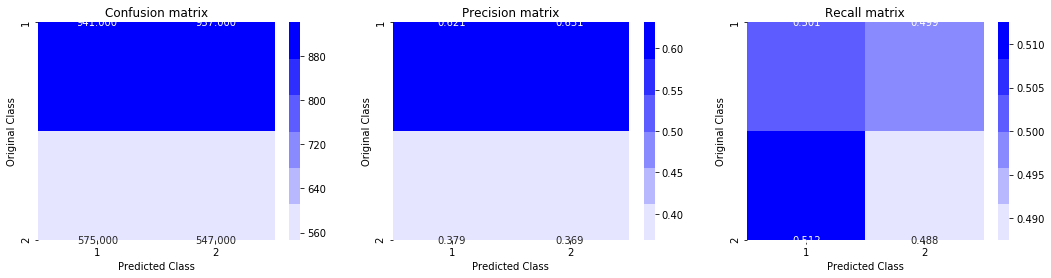

In [0]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 4.4 Logistic Regression with hyperparameter tuning

In [0]:
# hyperparam for SGD classifier.
alpha = [10 ** x for x in range(-5, 2)]

log_error_array = []

for i in alpha:
  clf = SGDClassifier(alpha = i, penalty ='l2', loss = 'log', random_state=42)
  clf.fit(x_train,y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(x_train,y_train)
  predict_y = sig_clf.predict_proba(x_test)
  log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
  print('For values of alpha = ',i,'the log loss is = ',log_loss(y_test, predict_y, labels =clf.classes_, eps=1e-15))

For values of alpha =  1e-05 the log loss is =  0.6610503113850993
For values of alpha =  0.0001 the log loss is =  0.5596064983484855
For values of alpha =  0.001 the log loss is =  0.5548678780873334
For values of alpha =  0.01 the log loss is =  0.5532966489877833
For values of alpha =  0.1 the log loss is =  0.5563115896348423
For values of alpha =  1 the log loss is =  0.5592467866190785
For values of alpha =  10 the log loss is =  0.5637148723676875


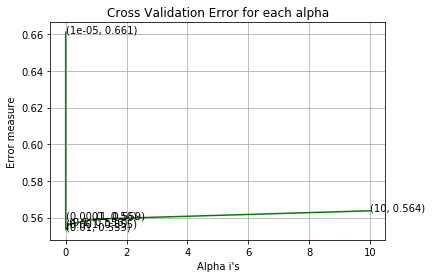

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of alpha =  0.01 the log loss for train is =  0.5069354594411394
For values of alpha =  0.01 the log loss for test is =  0.5532966489877833
Total number of data points : 3000


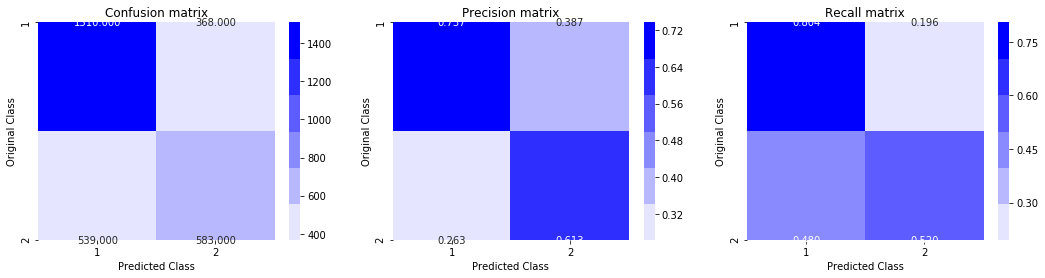

In [0]:
best_alpha = np.argmin(log_error_array)

clf = SGDClassifier(alpha =alpha[best_alpha], penalty='l2', loss='log', random_state =42)
clf.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method ='sigmoid')
sig_clf.fit(x_train,y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of alpha = ',alpha[best_alpha],'the log loss for train is = ',log_loss(y_train, predict_y, labels =clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of alpha = ',alpha[best_alpha],'the log loss for test is = ',log_loss(y_test, predict_y, labels =clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 4.5 Linear SVM with hyperparameter tuning

In [0]:
# hyperparam for SGD classifier.
alpha = [10 ** x for x in range(-5, 2)]

log_error_array = []

for i in alpha:
  clf = SGDClassifier(alpha = i, penalty ='l1', loss = 'hinge', random_state=42)
  clf.fit(x_train,y_train)
  sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
  sig_clf.fit(x_train,y_train)
  predict_y = sig_clf.predict_proba(x_test)
  log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
  print('For values of alpha = ',i,'the log loss is = ',log_loss(y_test, predict_y, labels =clf.classes_, eps=1e-15))

For values of alpha =  1e-05 the log loss is =  0.6610503113850993
For values of alpha =  0.0001 the log loss is =  0.5647056843978824
For values of alpha =  0.001 the log loss is =  0.5800740210493266
For values of alpha =  0.01 the log loss is =  0.5888858083893782
For values of alpha =  0.1 the log loss is =  0.611876827749364
For values of alpha =  1 the log loss is =  0.6407037266969277
For values of alpha =  10 the log loss is =  0.6508244132738731


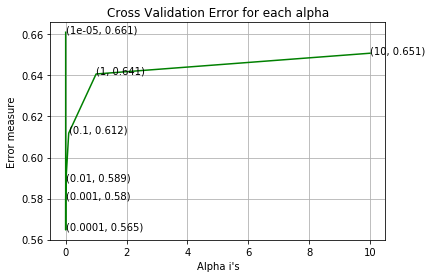

In [0]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of alpha =  0.0001 the log loss for train is =  0.5203899968851885
For values of alpha =  0.0001 the log loss for test is =  0.5647056843978824
Total number of data points : 3000


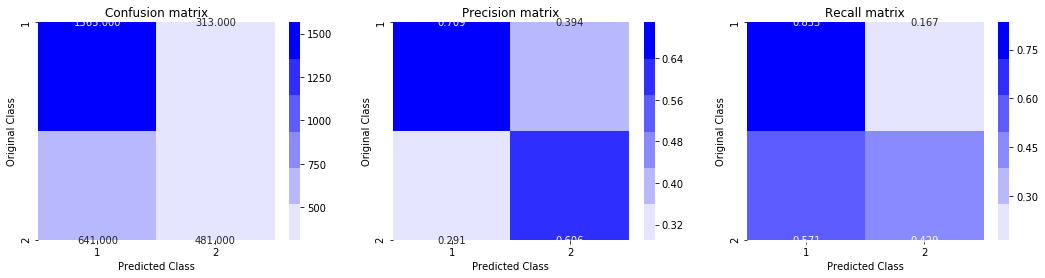

In [0]:
best_alpha = np.argmin(log_error_array)

clf = SGDClassifier(alpha =alpha[best_alpha], penalty='l1', loss='hinge', random_state =42)
clf.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method ='sigmoid')
sig_clf.fit(x_train,y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of alpha = ',alpha[best_alpha],'the log loss for train is = ',log_loss(y_train, predict_y, labels =clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of alpha = ',alpha[best_alpha],'the log loss for test is = ',log_loss(y_test, predict_y, labels =clf.classes_, eps=1e-15))

predicted_y = np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train,'train'), (d_test,'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train, y_train)
predict_y = bst.predict(d_test)
print("The test log loss is :",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.687048	valid-logloss:0.687888
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.63563	valid-logloss:0.642453
[20]	train-logloss:0.598134	valid-logloss:0.609827
[30]	train-logloss:0.5693	valid-logloss:0.58537
[40]	train-logloss:0.546954	valid-logloss:0.566858
[50]	train-logloss:0.528562	valid-logloss:0.552251
[60]	train-logloss:0.513465	valid-logloss:0.540405
[70]	train-logloss:0.501229	valid-logloss:0.53159
[80]	train-logloss:0.490449	valid-logloss:0.523762
[90]	train-logloss:0.481003	valid-logloss:0.517551
[100]	train-logloss:0.472619	valid-logloss:0.512282
[110]	train-logloss:0.465117	valid-logloss:0.50797
[120]	train-logloss:0.458422	valid-logloss:0.504361
[130]	train-logloss:0.452053	valid-logloss:0.501131
[140]	train-logloss:0.446018	valid-logloss:0.497859
[150]	train-logloss:0.44047	valid-logloss:0.495206
[160]	train-logloss:0.435592	valid-

Total number of data points : 3000


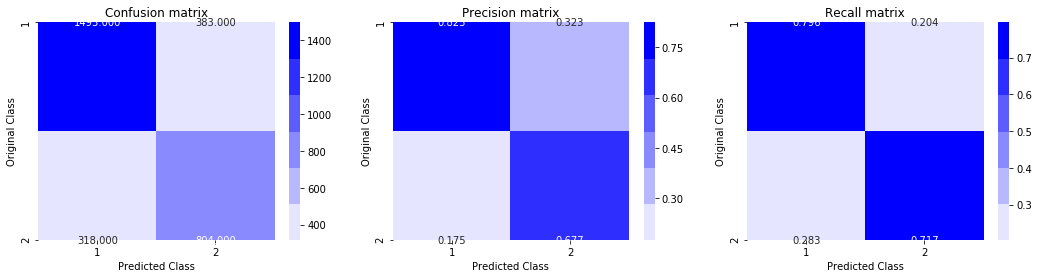

In [0]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)